#### NCSU GIS 714: Geospatial Computation and Simulations

## Surface Water Simulation: Geostatistical Simulations

This assignment was adapted from [
A Practical Guide to Geostatistical Mapping](http://spatial-analyst.net/book/system/files/Hengl_2009_GEOSTATe2c1w.pdf) by T. Hengl.

Contents:
1. Download data and create new GRASS location
2. Compute a smooth DEM and extract stream network from point data
3. Estimate the uncertainty in extracted streams with R

Additional Resources:
    
* [
GRASS GIS overview and manual](http://grass.osgeo.org/grass74/manuals/index.html)
    
* [GRASS book](http://www.grassbook.org/)

### 1. Download Dataset and Start GRASS GIS
Download and unzip dataset:

In [1]:
import os
import subprocess
import sys
import shutil

# Download zip
!curl https://ncsu-geoforall-lab.github.io/geospatial-simulations-course/assignments/data/baranja_elevations.zip -o ../data/baranjahill.zip

# Make destination directory for data
os.makedirs("../data/tmp", exist_ok = True)

# Unpack zip to new directory
shutil.unpack_archive("../data/baranjahill.zip", "../data/tmp", "zip")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  132k  100  132k    0     0   958k      0 --:--:-- --:--:-- --:--:--  958k


Launch GRASS GIS and create a new location (baranjahill) and mapset for this assignment:

In [3]:
# Ask GRASS GIS where its Python packages are.
# FOR WINDOWS:
# grass_call = "grass80"
# shell_setting = True
# FOR MAC/LINUX
grass_call = "grass"
shell_setting = False

sys.path.append(
    subprocess.check_output([grass_call, "--config", "python_path"], text=True, shell=shell_setting).strip()
)

# Import GRASS packages
import grass.script as gs
import grass.jupyter as gj

# Start GRASS Session
gj.init("../data", "nc_spm_08_grass7", "PERMANENT")

# Create new location for baranjahill
gs.create_location("../data", "baranjahill", filename="../data/tmp/elevations.prj")

# Start new GRASS session in new location
gj.init("../data", "baranjahill", "PERMANENT")

# Make a new mapset for this assignment
gs.run_command("g.mapset", flags="c", mapset="HW3_geostat_simulation", location="baranjahill")

Import the downloaded data to the location (baranjahill) and delete the zip archive and data since we won't need them anymore.

In [4]:
# Import baranjahill elevation vector
gs.run_command("v.import", input="../data/tmp/elevations.shp")

# Clean up
shutil.rmtree("../data/tmp")
os.remove("../data/baranjahill.zip")

Now, let's take a quick look at the baranjahill elevation data

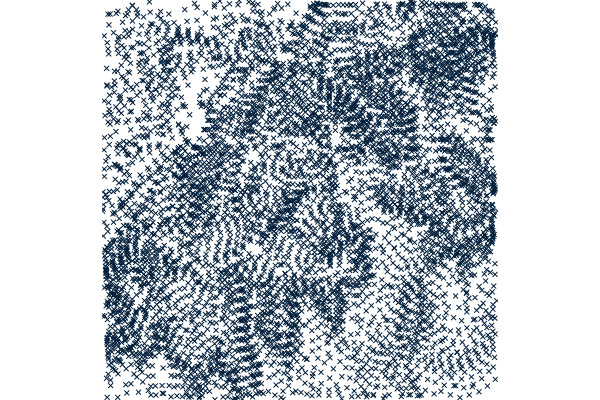

In [5]:
# Set region to the high resolution study area
gs.run_command("g.region", vector="elevations")

# Check out the points
img = gj.GrassRenderer(use_region=True)
img.d_vect(map="elevations")
# Display map
img.show()

#### *Question 1*

Get the basic information about the data, such as number of points, attribute names, and univariate statistics (modules: _[v.info](https://grass.osgeo.org/grass80/manuals/v.info.html)_, _[v.univar](https://grass.osgeo.org/grass80/manuals/v.univar.html)_). Display the points with a 1km grid (module: _[d.grid](https://grass.osgeo.org/grass80/manuals/d.grid.html)_, use `img.d_grid(size=1000, color="blue")` with GrassRenderer) to show the scale of the dataset. Looking at the spatial pattern, how they might have been acquired?

In [9]:
### Your Answer Here

Next, let's compute a histogram of the data distribution. We bin the points to 10m resolution grid and then create the histogram. The region is set to match grid created by R's spsample function, used later in the notebook.

projection: 99 (unknown)
zone:       0
datum:      ** unknown (default: WGS84) **
ellipsoid:  bessel
north:      5074351
south:      5070471
west:       6551799
east:       6555639
nsres:      10
ewres:      10
rows:       388
cols:       384
cells:      148992


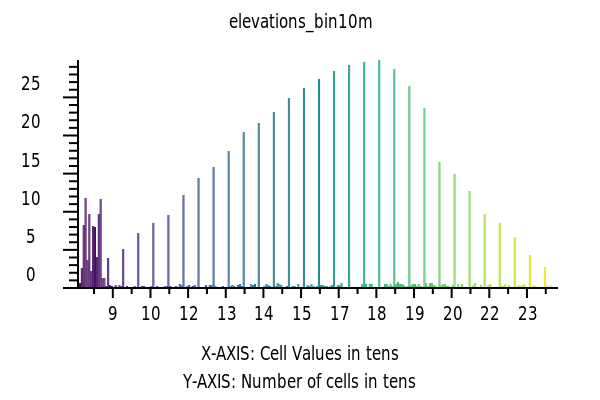

In [10]:
gs.run_command("g.region", n=5074351, s=5070471, e=6555639, w=6551799, res=10, flags="p")
gs.run_command("v.to.rast", input="elevations", out="elevations_bin10m", type="point", use="attr", attr="VALUE")

img = gj.GrassRenderer(use_region=True)
img.d_histogram(map="elevations_bin10m")
img.show()

#### *Question 2*
Can you explain the discrete spikes in the histogram?

In [ ]:
#### Your Answer Here

### 2. Compute a smooth DEM and extract stream network

#### *Question 3*

Interpolate a smooth DEM from the points using spline with tension. Also compute slope, aspect and curvatures to visualize the surface and its parameters (hint: we computed a smooth DEM from LiDAR points in Assignment 2B). Display the results with `InteractiveMap`. Then, extract the streams using a threshold of 300 and single-flow direction routing. Display the resulting streams (as a vector) and DEM with `GrassRenderer`.

In [ ]:
#### Your Answer Here

### 3. Estimate the uncertainty in extracted streams

Stream uncertainty arises from differences between a DEM and the actual surface. DEMs created from sparse points force us to interpolate the surface in between the points. This interpolation introduces uncertainty into the flow path of the stream. We will estimate uncertainty in the extracted streams due to elevation noise using a combination of R and GRASS GIS tools. We  use  an isotropic model variogram to measure the spatial dependence of elevation points. The isotropic model is appropriate here since there is no strong directionality in the ridges or valleys in our study area (i.e.  all theridges do not run N-S). With the variogram and original elevation points, we simulate 100 different surfaces and flow accumulation paths. 


#### FOR RUNNING LOCALLY
If you're running this in Binder, these packages have already been installed so you can skip the *Install rgrass* section. 

To run this on your local machine, you need to have R already installed.

You may need install some additional packages. First, we'll install the iteractive kernel to run R in Jupyter Notebooks. Here's an example with pip. If you use another python package management system (such as conda), this may not work for you.

In [ ]:
# Install Interactive Kernel for R
!pip install rpy2==3.1.0

After installing the interactive R kernel, we load it.

In [ ]:
%load_ext rpy2.ipython

Now, we can use the `%%R` cell magic. When this cell is interpreted, it's contents will be sent to R. We could also use line magic now with `%R` which would only send the line to R. 

We'll need to install several R packages and download rgrass from github.

In [ ]:
%%R

install.packages(c("rgdal", "gstat", "geoR", "devtools", "IRkernel"))

#### Install rgrass

In [ ]:
devtools::install_git("https://github.com/rsbivand/rgrass")

#### Simulating DEMs with a Variogram

Make sure the interactive kernel is loaded so we can use `%%R` cell magic.

In [ ]:
%load_ext rpy2.ipython

Read in libraries:

In [ ]:
%%R
library(rgrass7)
library(rgdal)
library(gstat)
library(geoR)
use_sp()

Read in elevation vector:

In [ ]:
%%R
elevations <- readVECT("elevations")

Subsample data and explore distribution of values in the data.

In [ ]:
%%R
sel <- runif(length(elevations@data[[2]])) < 0.2
Z.geo <- as.geodata(elevations[sel,"VALUE"])
plot(Z.geo, qt.col=grey(runif(4)))

#### *Question 4*

I THINK THIS QUESTION NEEDS IMPROVING: How many points are subsampled and displayed out of the given 6367? What is the method used for subsampling? What does Density in the histogram mean? Why is the histogram different from the  histograms derived in GRASS GIS?

In [ ]:
#### Your Answer Here

We plot empirical variogram in four directions using the subsampled data, Then we fit 
isotropic model variogram using the Matern covariance function:

In [ ]:
%%R
plot(variog4(Z.geo, max.dist=1000, messages=FALSE), lwd=2)
Z.svar <- variog(Z.geo, max.dist=1000, messages=FALSE)
Z.vgm <- variofit(Z.svar, ini=c(var(Z.geo$data), 1000), fix.nugget=T, nugget=0)
env.model <- variog.model.env(Z.geo, obj.var=Z.svar, model=Z.vgm)
plot(Z.svar, envelope=env.model); lines(Z.vgm, lwd=2);

Compute 100 realizations of a DEM (10m resolution) using Stochastic Conditional Gaussian Simulation
with Matern covariance function (this may take few minutes so be patient). Plot the first 4 simulations.

In [ ]:
%%R
demgrid <- spsample(elevations, type="regular", cellsize=c(10,10), offset=c(0.5,0.5))
demgrid <- spTranform(demgrid, CRS=CRS("+proj=tmerc +lat_0=0 +lon_0=18 +k=0.9999 +x_0=6500000 +y_0=0 +ellps=bessel +units=m +no_defs"))
gridded(demgrid) <- TRUE
fullgrid(demgrid) <- TRUE

elevations <- spTranform(elevations, CRS=CRS("+proj=tmerc +lat_0=0 +lon_0=18 +k=0.9999 +x_0=6500000 +y_0=0 +ellps=bessel +units=m +no_defs"))

Z.ovgm <- vgm(psill=Z.vgm$cov.pars[1], model="Mat", range=Z.vgm$cov.pars[2], nugget=Z.vgm$nugget, kappa=1.2)
N.sim <- 100
DEM.sim <- krige(elevations$VALUE ~ 1, elevations, demgrid, Z.ovgm, nmax=30, nsim=N.sim)
fullgrid(DEM.sim) <- TRUE
spplot(DEM.sim[1:4], col.regions=grey(seq(0,1,0.025)))

Save simulated elevation rasters as GRASS rasters (`writeRAST`), compute a mean simulated DEM and its standard deviation. The mean of elevations rasters is the final simulated  DEM  surface  and  the  standard  deviation of all the simulated elevation rasters describes the elevation uncertainty. Finally, we derive streams from each of the simulated DEMs:

In [ ]:
%%R
# Save elevation rasters to GRASS
for(i in 1:N.sim) {writeRAST(DEM.sim[i], paste("simulated_", i, sep=""))}

# Compute mean DEM and standard deviation
execGRASS("g.list", type="raster", pattern="simulated_*", output="tmp_list_simulated.txt")
execGRASS("r.series", file="tmp_list_simulated.txt", output="simulated_mean", method="average")
execGRASS("r.series", file="tmp_list_simulated.txt", output="simulated_std", method="stddev")

# Derive Streams for each elevation raster (output is rasters)
for(i in 1:N.sim) {execGRASS("r.watershed", elevation=paste("simulated_", i, sep=""),
 threshold=30, stream=paste("stream_", i, sep=""), flags=c("quiet"))}

Compute number of streams extracted at each 10m grid cell (count), derive probability that a grid cell has a stream and associated error map. 

We count the number of simulated streams that flow through each pixel and divide by the number of simulations(100), yielding the probability a given pixel actually contains a stream. We'll keep using `rgrass` here since we need `N.sim`, a variable stored in R.

In [ ]:
%%R
execGRASS("g.list", type="raster", pattern="stream*", output="tmp_list_stream.txt")
execGRASS("r.series", file="tmp_list_stream.txt", output="count", method="count")
execGRASS("r.mapcalc", expression=paste("prob = float(count)/", N.sim))
execGRASS("r.mapcalc", expression="error = -prob * log(prob) - (1-prob)* log(1-prob)")

Now, we can switch back to python to visualize and compare our results.

#### *Question 6*

Modify the code below to compare the splined DEM from Question 3 with the simulated mean (`simulated_mean`) and a single realization i=10 (`simulated_10`) (hint: you can copy a color table from one raster to another with r.colors. For example, `gs.run_command("r.colors", map="simulated", raster="interpolated")`). Comment briefly on the differences.

In [ ]:
#### Your Answer Here
gs.run_command("r.colors", map="simulated_mean", raster="SPLINED")

# Create Interactive Map
fig = gj.InteractiveMap(width = 600, use_region=True)
fig.add_raster("", opacity=1.0)
fig.add_raster("", opacity=1.0)
fig.add_raster("", opacity=1.0)
fig.show()

Let's look at the standard deviation of the simluated elevations.

In [ ]:
# Create Interactive Map
fig = gj.InteractiveMap(width = 600, use_region=True)
fig.add_raster("simulated_std", opacity=1.0)
fig.show()

#### *Question 7*
Can you explain the pattern of standard deviations in `simulated_std` (hint: add the elevations point layer)?

In [1]:
#### Your Answer Here

#### *Question 8*
Use `Grass3dRenderer` to drape the probability raster `prob` over elevation layer `simulated_mean` in 3D. Where is the high probability of streams and where we cannot map the streams reliably? Which topographic parameter may explain the stream extraction uncertainty?

In [ ]:
### Your Answer Here.

### Additional Information
* [Website](https://github.com/ncsu-geoforall-lab/geospatial-simulations-course)
    
* [Computing Help](https://help.ncsu.edu/)
    
* [GIST Home](https://geospatial.ncsu.edu/)
    
* [Disclaimer](https://www.ncsu.edu/policies/prr-disclaimer.php)
    
* [Accessibility](https://oit.ncsu.edu/itaccess)

* License: 2018 [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0/)
  
* [NCSU GeoForAll Lab](https://geospatial.ncsu.edu/geoforall/)